In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *

Using TensorFlow backend.


In [2]:
### READ DATA ###

df = pd.read_csv('C:/Users/marco.cerliani/OneDrive/Downloads/DATA/HRSS_anomalous_optimized.csv.zip')

print(df.shape)
df.head()

(19634, 20)


,Timestamp,Labels,I_w_BLO_Weg,O_w_BLO_power,O_w_BLO_voltage,I_w_BHL_Weg,O_w_BHL_power,O_w_BHL_voltage,I_w_BHR_Weg,O_w_BHR_power,O_w_BHR_voltage,I_w_BRU_Weg,O_w_BRU_power,O_w_BRU_voltage,I_w_HR_Weg,O_w_HR_power,O_w_HR_voltage,I_w_HL_Weg,O_w_HL_power,O_w_HL_voltage
0,0.000000,0,7.0,0.0,0.0,-547.0,0.0,0.0,-874.0,12.0,1.0,-32.0,0.0,0.0,0.0,2560.0,24.0,0.0,3434.0,24.0
1,0.043999,0,7.0,0.0,0.0,-547.0,0.0,0.0,-874.0,12.0,1.0,-32.0,0.0,0.0,0.0,2560.0,24.0,0.0,3434.0,24.0
2,0.099998,0,7.0,0.0,0.0,-547.0,0.0,0.0,-874.0,12.0,1.0,-32.0,0.0,0.0,0.0,2560.0,24.0,0.0,3434.0,24.0
3,0.143997,0,7.0,0.0,0.0,-547.0,0.0,0.0,-874.0,12.0,1.0,-32.0,0.0,0.0,0.0,2560.0,24.0,0.0,3434.0,24.0
4,0.249001,0,7.0,0.0,0.0,-547.0,0.0,0.0,-874.0,7.0,1.0,22.0,18471.0,47.0,0.0,5764.0,26.0,0.0,5008.0,24.0


In [3]:
features = ['I_w_BLO_Weg', 'O_w_BLO_power', 'O_w_BLO_voltage', 'I_w_BHL_Weg', 
            'O_w_BHL_power', 'O_w_BHL_voltage', 'I_w_BHR_Weg', 'O_w_BHR_power', 
            'O_w_BHR_voltage', 'I_w_BRU_Weg', 'O_w_BRU_power', 'O_w_BRU_voltage', 
            'I_w_HR_Weg', 'O_w_HR_power', 'O_w_HR_voltage', 'I_w_HL_Weg', 
            'O_w_HL_power', 'O_w_HL_voltage']

In [4]:
### LABEL DISTRIBUTION ###

df.Labels.value_counts()

0    15117
1     4517
Name: Labels, dtype: int64

Text(0,0.5,'Failure')

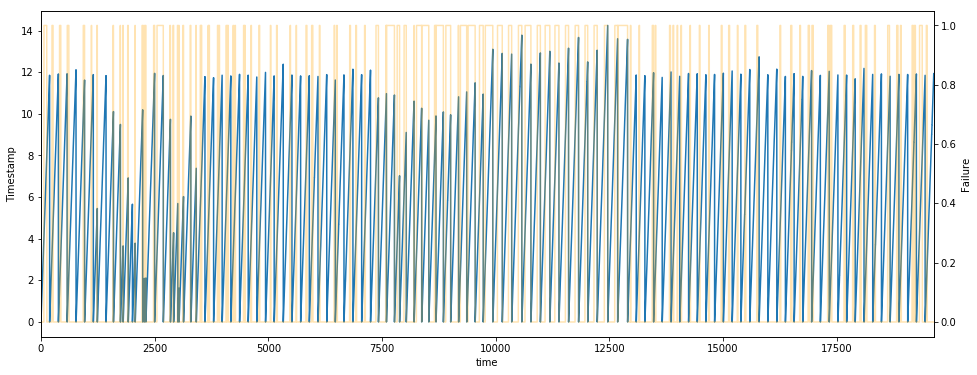

In [5]:
### CYCLE vs LABEL DISTRIBUTION ###

df.Timestamp.plot(figsize=(16,6))
plt.xlabel('time')
plt.ylabel('Timestamp')
plt.twinx()
plt.plot(df.Labels[1:], alpha=0.3, c='orange')
plt.ylabel('Failure')

Text(0,0.5,'standard deviation')

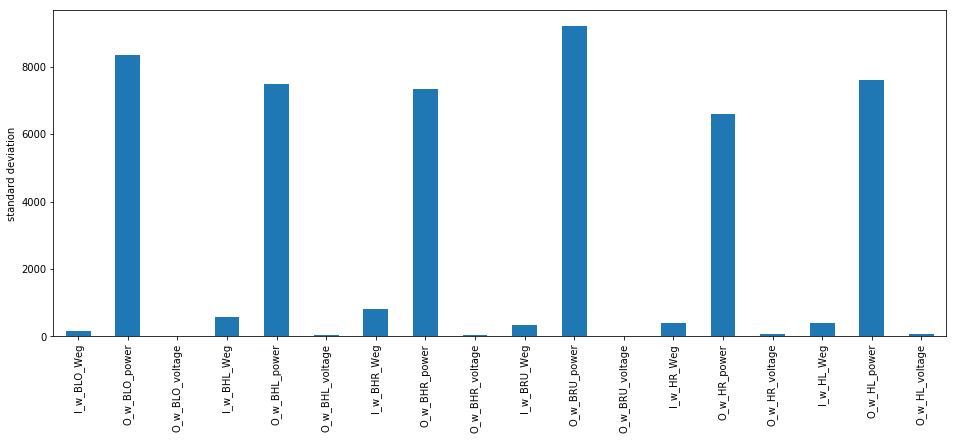

In [6]:
### SENSOR FEATURES VARIANCE ###

df.loc[:,features].std().plot.bar(figsize=(16,6))
plt.ylabel('standard deviation')

In [7]:
### UTILITY FUNCTION TO GENERATE SEQUENCE FOR LSTM ###

def gen_sequence(df, seq_length):
    
    seq_df = []
    
    for start, stop in zip(range(0, len(df)-seq_length), range(seq_length, len(df))):
        seq_df.append(df[start:stop, :])
        
    return np.asarray(seq_df)

In [8]:
### CREATE AND STANDARDIZE WINDOW SEQUENCES FOR EVERY CYCLE ###

sequence_length = 8

X_train, X_test = [], []
Y_train, Y_test = [], []

id_fault = np.append(np.where(df.Timestamp == 0)[0], len(df))

for i in tqdm.tqdm(range(1, len(id_fault))):
    
    cycle = np.arange(id_fault[i-1], id_fault[i])
    
    if len(cycle) > sequence_length:
        
        partial = df.loc[cycle, features].copy()
        
        init = partial.iloc[0].values + 0.001
        partial = pd.DataFrame([(row/init) for row in partial.values])
        partial.columns = features

        partial['Timestamp'] = df.loc[cycle, 'Timestamp'].values
        partial['Labels'] = df.loc[cycle, 'Labels'].values
        
        y = partial.Labels.values
        x_train = partial.loc[:int(len(partial)*0.9), features]
        x_test = partial.loc[int(len(partial)*0.9):, features]
        
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        
        scale_df = np.vstack([x_train, x_test])
        seq_df = gen_sequence(scale_df, sequence_length)
                
        Y_train.append(y[sequence_length:len(x_train)])
        Y_test.append(y[len(x_train):])
        X_train.append(seq_df[:len(x_train)-sequence_length])
        X_test.append(seq_df[len(x_train)-sequence_length+1:])
        
    else:
        continue

X_train, X_test = np.concatenate(X_train), np.concatenate(X_test)
print(X_train.shape, X_test.shape)
Y_train, Y_test = np.concatenate(Y_train), np.concatenate(Y_test)
print(Y_train.shape, Y_test.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:01<00:00, 80.47it/s]


(16837, 8, 18) (1909, 8, 18)
(16837,) (1909,)


In [9]:
### LABEL DISTRIBUTION OF TEST SET ###

pd.value_counts(Y_test)

0    1142
1     767
dtype: int64

0


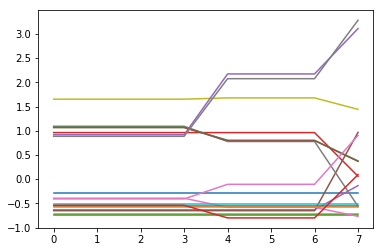

In [10]:
### PLOT EXEMPLE OF SAMPLE ###

_id_ = 39

print(Y_train[_id_])
plt.plot(X_train[_id_])
np.set_printoptions(False)

In [11]:
### DEFINE SIAMESE NETWORK ARCHITECTURE ###

def SiamesNet():
    
    left_input = Input((sequence_length, len(features)))
    right_input = Input((sequence_length, len(features)))

    lstmnet = Sequential([
        BatchNormalization(),
        LSTM(128, activation='relu', return_sequences=True, input_shape=(sequence_length, len(features))),
        LSTM(32, activation='relu')
    ])

    
    encoded_l = lstmnet(left_input)
    encoded_r = lstmnet(right_input)

    L1_layer = Lambda(lambda tensor: K.abs(tensor[0] - tensor[1]))

    L1_distance = L1_layer([encoded_l, encoded_r])
    drop = Dropout(0.2)(L1_distance)
    prediction = Dense(1,activation='sigmoid')(drop)
    model = Model(inputs=[left_input,right_input],outputs=prediction)
    
    return model

In [12]:
### GENERATE PAIR SAMPLES FOR SIAMESE NETWORK ###

np.random.seed(33)

left_input = []
right_input = []
targets = []
pairs = 3

for i in range(len(Y_train)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i:
            compare_to = random.randint(0,len(Y_train)-1)
        left_input.append(X_train[i])
        right_input.append(X_train[compare_to])
        if Y_train[i] == Y_train[compare_to]: # They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)  

In [13]:
### LABEL DISTRIBUTION OF AUGMENTED DATASET ###

pd.value_counts(targets)

1.0    33136
0.0    17375
dtype: int64

In [14]:
### FIT SIAMESE NETWORK ###

siamese_net = SiamesNet()
siamese_net.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-3), metrics=['accuracy'])

siamese_net.fit([np.asarray(left_input),np.asarray(right_input)], targets, batch_size=512, epochs=50, 
                validation_split=0.15, verbose=2)

Train on 42934 samples, validate on 7577 samples
Epoch 1/50
 - 13s - loss: 0.6430 - acc: 0.6523 - val_loss: 0.6268 - val_acc: 0.6759
Epoch 2/50
 - 10s - loss: 0.6213 - acc: 0.6721 - val_loss: 0.6131 - val_acc: 0.6877
Epoch 3/50
 - 10s - loss: 0.6076 - acc: 0.6872 - val_loss: 0.6066 - val_acc: 0.6905
Epoch 4/50
 - 11s - loss: 0.5994 - acc: 0.6965 - val_loss: 0.5992 - val_acc: 0.7008
Epoch 5/50
 - 11s - loss: 0.5894 - acc: 0.7053 - val_loss: 0.5988 - val_acc: 0.6963
Epoch 6/50
 - 11s - loss: 0.5802 - acc: 0.7113 - val_loss: 0.5985 - val_acc: 0.7034
Epoch 7/50
 - 11s - loss: 0.5711 - acc: 0.7207 - val_loss: 0.5944 - val_acc: 0.6994
Epoch 8/50
 - 11s - loss: 0.5563 - acc: 0.7294 - val_loss: 0.5761 - val_acc: 0.7147
Epoch 9/50
 - 10s - loss: 0.5386 - acc: 0.7445 - val_loss: 0.5758 - val_acc: 0.7118
Epoch 10/50
 - 10s - loss: 0.5253 - acc: 0.7548 - val_loss: 0.5669 - val_acc: 0.7305
Epoch 11/50
 - 10s - loss: 0.5045 - acc: 0.7711 - val_loss: 0.5489 - val_acc: 0.7491
Epoch 12/50
 - 10s - loss

In [15]:
### COMPUTE PREDICTION ###

np.random.seed(33)

real = []
pred = []
rep = 4

for j,i in enumerate(tqdm.tqdm(Y_test)):
    
    test = X_test[j]

    nofault = np.random.choice(np.where(Y_train == 0)[0], rep)
    nofault = X_train[nofault]
    nofault_sim = np.max([float(siamese_net.predict([test[np.newaxis,:,:],s[np.newaxis,:,:]])) for s in nofault])

    fault = np.random.choice(np.where(Y_train == 1)[0], rep)
    fault = X_train[fault]
    fault_sim = np.max([float(siamese_net.predict([test[np.newaxis,:,:],s[np.newaxis,:,:]])) for s in fault])
    
    pred.append('nofault' if nofault_sim > fault_sim else 'fault')
    real.append('nofault' if i == 0 else 'fault')

100%|██████████████████████████████████████████████████████████████████████████████| 1909/1909 [00:25<00:00, 74.23it/s]


In [16]:
print(classification_report(real, pred))

              precision    recall  f1-score   support

       fault       0.70      0.28      0.40       767
     nofault       0.66      0.92      0.77      1142

    accuracy                           0.66      1909
   macro avg       0.68      0.60      0.58      1909
weighted avg       0.67      0.66      0.62      1909



In [17]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

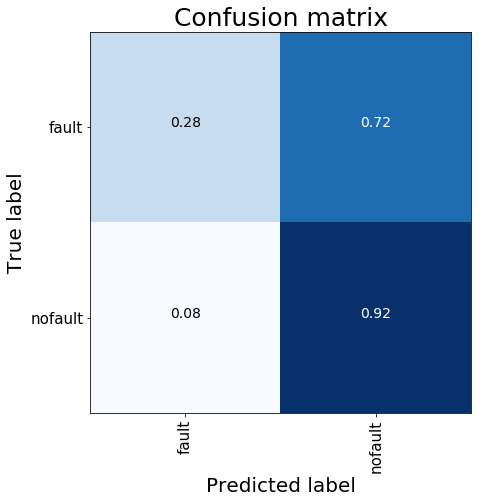

In [18]:
cnf_matrix = confusion_matrix(real, pred)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(real), title="Confusion matrix")
plt.show()

In [19]:
### DUMMY CLASSIFIER ACCURACY (always nofault) ###

sum(np.asarray(real) == 'nofault') / (sum(np.asarray(real) == 'fault') + sum(np.asarray(real) == 'nofault'))

0.5982189628077528